In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.vision import *

### Data

In [5]:
#path = Path('D:\College\BE\BE PROJECT\COVID-19-master\X-Ray_Image_DataSet')
path = Path('/content/drive/MyDrive/X-Ray_Image_DataSet')

In [6]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [7]:
np.random.seed(41)
#data = ImageDataBunch.from_folder(path,  test='/content/drive/MyDrive/X-Ray_Image_DataSet/test',
#        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()
#data = ImageDataBunch.from_folder(path, train='D:\\College\\BE\\BE PROJECT\\COVID-19-master\\X-Ray_Image_DataSet\\train', test='D:\\College\\BE\\BE PROJECT\\COVID-19-master\\X-Ray_Image_DataSet\\test', valid_pct=0.2, ds_tfms=get_transforms(), size=(256,256),bs=32).normalize()
data = ImageDataBunch.from_folder(path, train='/content/drive/MyDrive/X-Ray_Image_DataSet/train', test='/content/drive/MyDrive/X-Ray_Image_DataSet/test', valid_pct=0.2, ds_tfms=get_transforms(), size=(256,256)).normalize()

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Covid-19', 'No_findings', 'Pneumonia'], 3, 2400, 600)

In [9]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 2400
Number of examples in validation: 600


In [10]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 256, 256]), torch.Size([64]))

---

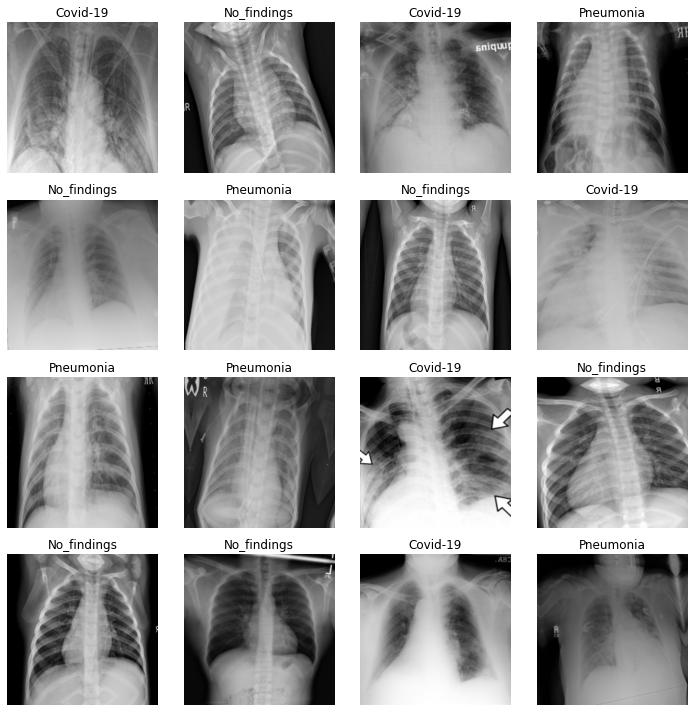

In [11]:
data.show_batch(rows=4, figsize=(10,10))

## DarkCovidNet (modified Darknet model)

In [12]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [13]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [14]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

In [15]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 3),
    Flatten(),
    nn.Linear(507, 3)
)

In [21]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [22]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.876150,1.129228,0.335000,11:10
1,0.769381,0.668009,0.716667,01:12
2,0.692534,0.570053,0.768333,01:07
3,0.639267,0.599935,0.755000,01:07
4,0.598211,0.490254,0.793333,01:07
5,0.583582,0.532595,0.801667,01:08
6,0.565578,0.503580,0.788333,01:07
7,0.538721,0.502210,0.800000,01:08
8,0.508640,0.492555,0.788333,01:07
9,0.483929,1.813365,0.540000,01:08


In [ ]:
learn.recorder.plot_losses()

In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) # Predicting without TTA

In [ ]:
accuracy(probs,targets)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) # shows whole confusion matrix
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings', 'Pneumonia']
print(classification_report(y_true1, y_pred1, target_names=target_names))

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
cm_fig = interp.plot_confusion_matrix(return_fig=True)
ax = cm_fig.gca()
ax.set_ylim(interp.data.c - .5, - .5);